### Load Data

In [1]:
import pandas as pd

# Input path and filename
path = 'D:/Git_Projects/5. Master_thesis/Datasets/'

# Load files into a pandas dataframes
file = path + 'Dataset.xlsx'
df = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True)

# Set index
df = df.set_index("Date")

In [2]:
test_size = 0.2         # Train/Test split
dep_var = 'TIV'         # Dependant variable (TIV or Orders)

In [3]:
import plotly.graph_objs as go
title = dep_var + ' 2011–2022'
fig= go.Figure()
fig.add_trace(go.Scatter(dict(x=df.index, y=df[dep_var], mode='lines+markers', name= 'Cars')))
fig.update_layout(title=go.layout.Title(
 text=title,
 xref='paper',x=0),
 margin=dict(l=10, r=0, t=50, b=50),
 xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Date',font=dict(
 family='Courier New, monospace',
 size=6,
 color='#7f7f7f'))),
 yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Retails',font=dict(
 family='Courier New, monospace',
 size=18,
 color='#7f7f7f'))))
fig.show()

### Seasonality

In [5]:
import ipywidgets as widgets
import plotly.graph_objs as go

#Generate a widget
widget = widgets.IntRangeSlider(value=[2011, 2022], min=2011, max=2022, step=1, description='Time Period:', 
        disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='d')
widget

#Prepare Data
years = widget.value
years = list(range(years[0],years[1]+1))
df['Year'] = pd.DatetimeIndex(df.index).year
df['Month'] = [d.strftime('%b') for d in df.index]

#Draw Plot
fig = go.Figure()
for i,y in enumerate(years):
    if i<len(years):
        fig.add_trace(go.Scatter(
            x=df[df['Year']==years[i]].Month.tolist(),
            y=df[df['Year']==years[i]].Orders.round(2).tolist(),
            name=str(years[i])))
fig.update_layout(title=go.layout.Title(
        text="Seasonal Trend of Monthly Retails",
        xref="paper",
        x=0),
    margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Month",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Retails",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))
fig.update_yaxes(nticks=10)
   
fig.show()

### Rolling Statistics

A rolling average is a great way to visualize how the dataset is trending. As the dataset provides counts by month, a window size of 12 will give us the annual rolling average.

We will also include the rolling standard deviation to see how much the data varies from the rolling average.

In [8]:
import matplotlib.pylab as plt

# Determine rolling statistics
# Wwindow size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_avg"] = df[dep_var].rolling(window=12).mean() 
df["rolling_std"] = df[dep_var].rolling(window=12).std()

title = 'Rolling Mean & Standard Deviation'
fig= go.Figure()
fig.add_trace(go.Scatter(dict(x=df.index, y=df[dep_var], mode='lines+markers', name= 'Number of Cars')))
fig.add_trace(go.Scatter(dict(x=df.index, y=df['rolling_avg'], mode='lines', name= 'Rolling Avg')))
fig.add_trace(go.Scatter(dict(x=df.index, y=df['rolling_std'], mode='lines', name= 'Rolling Std')))
fig.update_layout(title=go.layout.Title(
 text=title,
 xref='paper',x=0),
 margin=dict(l=10, r=0, t=50, b=50),
 xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Date',font=dict(
 family='Courier New, monospace',
 size=18,
 color='#7f7f7f'))),
 yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Number of cars',font=dict(
 family='Courier New, monospace',
 size=18,
 color='#7f7f7f'))))
fig.show()

### Augmented Dickey–Fuller Test

The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not. Similar to a t-test, we set a significance level before the test and make conclusions on the hypothesis based on the resulting p-value.

* Null Hypothesis: The data is not stationary.

* Alternative Hypothesis: The data is stationary.

For the data to be stationary (ie. reject the null hypothesis), the ADF test should have:

* p-value <= significance level (0.01, 0.05, 0.10, etc.)

If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.

Results of Dickey-Fuller Test:
Test Statistic                  -5.198878
p-value                          0.000009
#Lags Used                       1.000000
Number of Observations Used    138.000000
Critical Value (1%)             -3.478648
Critical Value (5%)             -2.882722
Critical Value (10%)            -2.578065
dtype: float64


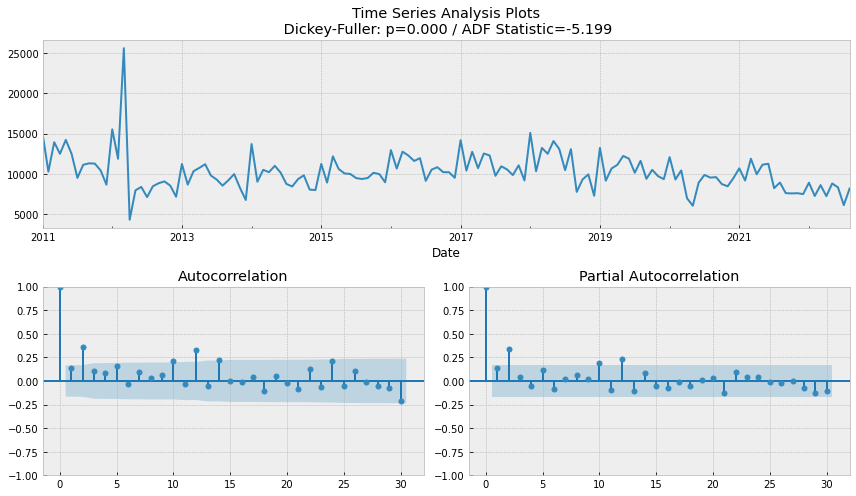

In [11]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Time series analysis plot
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        result = sm.tsa.stattools.adfuller(y)
        adf = result[0]
        p_value = result[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.3f} / ADF Statistic={1:.3f}'.format(p_value, adf))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')
        plt.tight_layout()
        
# Data Stationarity check using Augmented Dickey Fuller(ADF) test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='BIC',regression='c')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

tsplot(df[dep_var], lags=30)
adf_test(df[dep_var])     

### ARIMA

In [12]:
pip install pmdarima --user

  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\ne74255\\AppData\\Roaming\\Python\\Python38\\site-packages\\~umpy\\.libs\\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll'
Check the permissions.



In [13]:
import pmdarima as pm

#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df[dep_var'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

ModuleNotFoundError: No module named 'pmdarima'